In [1]:
#1 HOG Feature model train
#kütüphaneleri yükledik
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

#HOG Feature model oluşturma
#hog feature model parametrelerini oluşturduk
FeatureVecSize = 7056; #train edilicek resimlerin hog shape i
winSize = (60,60)
blockSize = (8,8)
blockStride = (4,4)
cellSize = (4,4)
nbins = 9

#resimlerin dosya yolunu belirttik

dir='dataset/trainingData'
categories=[]

#resimlerin dosya isimleri için for döngüsü oluşturduk "1,2,3,4,.."
for i in range (59):
    categories.append("{}".format(i))

    
categories.remove('0')
    
#hog feature hesaplama metodunu oluşturduk
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)
#train edilicek data için array oluşturduk train edilicek datayı yatay bir array haline getirdik 
trainData = np.zeros((1, FeatureVecSize), dtype = "float32")
#labellama için array oluşturduk
labels = np.zeros((1, 1), dtype = "float32")
for category in categories:
    #dosya yolundan resimleri aktarmak için bir path belirledik
    path=os.path.join(dir,category)
    #categories listesindeki öğeleri indekslerine göre labelladık
    label=categories.index(category)
    
    for img in os.listdir(path):
        #belirtilen yoldaki resimleri açtık
        imgpath = os.path.join(path,img)
        obj_img = cv2.imread(imgpath,cv2.IMREAD_GRAYSCALE)
        try:
            #hog feature hesaplattık
            hog_array = hog.compute(obj_img)
            #hog hesaplatılan datayı yatay hale getirdik
            out = (hog_array).reshape(-1,FeatureVecSize)
            #trainData ve labels arraylerine datayı ve labelları ekledik
            trainData = np.float32( np.insert(trainData, -1, out, 0)) 
            labels = np.float32( np.insert(labels, -1, label, 0))
        #hata aldığımızda işleme devam etmesi için except ve try döngülerini kullandık    
        except Exception as e:
            pass


In [2]:
#2 SVM Classifier Model Oluşturma:

x_train,x_test,y_train,y_test = train_test_split(trainData,labels,test_size=0.2)

model = SVC(C=15,kernel='rbf',gamma='auto')

model.fit(x_train,y_train)


D:\Okul\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=15, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Accuracy:  0.9398280802292264
Predict:  .


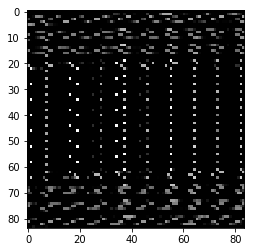

In [3]:
#Model Doğruluğunu test etme

#labellanmış train data üzerinden yaptığı tahminin denk geldiği harfi görmek için tahminlenicek öğelerin olduğu liste yaptık
ayirici='abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ,;:?!.'
categories=[]
for i in ayirici:
    categories.append(i)
#tahminleme ve doğruluk oranı hesaplattık
prediction=model.predict(x_test)
accuracy=model.score(x_test,y_test)

print('Accuracy: ',accuracy)
print('Predict: ',categories[int(prediction[0])])

ornek=x_test[0].reshape(84,84)
plt.imshow(ornek,cmap='gray')
plt.show()

In [10]:
#4Kelimeleri Ayırma
#önce satırları sonra kelimeleri ayırıyoruz
import cv2
import numpy as np

# load image
img = cv2.imread("text.jpg")

# convert to gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# threshold the grayscale image
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# use morphology erode to blur horizontally
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (151, 3))
morph = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel)

# use morphology open to remove thin lines from dotted lines
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 17))
morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)

# find contours
cntrs = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cntrs = cntrs[0] if len(cntrs) == 2 else cntrs[1]

# Draw contours excluding the topmost box
sorted_cntrs = sorted(cntrs, key=lambda ctr: cv2.boundingRect(ctr)[1],reverse=False)
result = img.copy()
#bulduğumuz her bir satır için roi çıkartırıp, bu roiler içinden kelimeleri buluyoruz
sayac=0
for i,c in enumerate(sorted_cntrs):
    box = cv2.boundingRect(c)
    x,y,w,h = box
    h=h+10
    y=y-10
    #Roi yi çıkartıyoruz grayscale,blurlama ve trashold ile kontör bulma yapıyoruz
    rowRoi = img[y:y+h, x:x+w]
    grayRowRoi = cv2.cvtColor(rowRoi, cv2.COLOR_BGR2GRAY)
    blurRowRoi = cv2.blur(grayRowRoi,(5,5))
    ret,thresh = cv2.threshold(blurRowRoi,127,255,cv2.THRESH_BINARY_INV)
    im2,ctrs, hier = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    #bulduğumuz he rbir kontörü x ekseninde sırlaıyoruz
    sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
    s=10
    sm=-5
    #boşlukları hulmak için her bir kontörün boundingrectlerinin x+w değerinden x değerini çıkarıcaz bulunan farka göre boşluk
    #olup olmadığını anlıycaz
    #ilk değerin x+w değeri olmadığı için bunu kendi x değerine eşitliyoruz
    firstX,_,_,_=cv2.boundingRect(sorted_ctrs[0])
    xpw=firstX+sm
    for i, ctr in enumerate(sorted_ctrs):

        x, y, w, h = cv2.boundingRect(ctr)
        w += s
        h += 15
        x += sm
        y += -12
        #kontör sayısı 20 den yüksekse nokta değildir bu yüzden sadece 20 den yukarı kontörlere işlem yaptırdık
        if len(ctr)>20:
            sayac=int(sayac)
            sayac+=1
            sayac=str(sayac)
            roi = rowRoi[y:y+h, x:x+w]
            dir='dataset/exampleimgs1'
            path=os.path.join(dir,sayac)
            #önceki değerin (X+w)- şimdiki değerin x' inin farkının mutlak değerini aldık çünkü bazen (-)eksili değer çıkabilir
            #bu mutlak değer 9 dan büyükse boşluk vardır o zaman boş bir png dosyası kaydederiz 
            if abs(xpw-x)>9:
                #roi değeri oluştururken verdiğimiz değerler olmaması gereken değerler ise roi boş bir png oluşturur
                EmptyImg = img[2:1,2:1]
                cv2.imwrite('{}.png'.format(path),EmptyImg)
                sayac=int(sayac)
                sayac+=1
                sayac=str(sayac)
                path=os.path.join(dir,sayac)
            xpw=x+w
            cv2.imwrite('{}.png'.format(path), roi)



In [8]:
#5 Tahminleme ve yazdırma
#Ayırıcı elimizdeki 58 karakterin her birni sırasıyla yazdırdık ve ayırıcı listesi oluşturduk.

ayirici='abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ,;:?!.'
#model tahminleme yapınca datasetteki indeksi catogeries indeksiyle eşliycek böylece doğru karakteri yazdırmış olacağız
categories=[]
for i in ayirici:
    categories.append(i)
#üsteki kodda kelimeleri kaydederken indeks değerini yazdırmak için kullandığımız sayac değişkeni burdda tekrar int değerine dönüştürdük
sayac=int(sayac)
tahmin_liste=[]

for i in range(sayac):
    indeks=str(i+1)
    img = cv2.imread('dataset/exampleimgs1/{}.png'.format(indeks),cv2.IMREAD_GRAYSCALE)
    #img boş değilse tahminleme yaptırıyoruz
    if img is not None:
        img=cv2.resize(img,(60,60))
        imgList = np.zeros((1, 7056), dtype = "float32")
        hog_array_img = hog.compute(img)
        out_img = (hog_array_img).reshape(-1,FeatureVecSize)
        imgList = np.float32( np.insert(imgList, -1, out_img, 0))
        prediction=model.predict(imgList)
        tahmin_liste.append(categories[int(prediction[0])])
    #img boş ise tahmin listesine ' ' boşluk koyduruyoruz
    else:
        tahmin_liste.append(' ')

print(tahmin_liste)
print(len(tahmin_liste))

['V', 't', ' ', 'n', 'g', ' ', 't', 'h', 'e', ' ', 'm', 'C', 'f', 'h', 'o', 'd', ' ', 'f', 'o', ' ', 'r', 'C', 'n', 'o', 'V', 'a', 't', '.', ' ', 'm', '.', 'c', 'h', 'a', 'h', 'w', 'g', 'm', ' ', 'w', 'n', ' ', 'p', 'r', 'w', 'n', 'f', ',', ' ', 'd', 'w', 'g', 'Q', 'C', 'n', 'g', '.', ' ', 'W', 'h', ' ', 'p', 'r', 'w', 'h', 'f', ' ', 'O', 'r', ' ', 'h', 'a', 'h', 'd', ' ', 'p', 'r', 'n', 'n', 'f', '.', 'd', ' ', 'a', 'r', 'f', 'n', 'c', 'v', 'C', ' ', 'n', 'n', 't', 'C', 'r', 'C', 'g', 'f', '.', 'd', 'v', 'n', ' ', 'e', 'd', 'n', 't', 'a', 'b', 'n', 'C', ' ', 'm', 'a', 'h', 'u', 'g', 'c', 'r', 'w', 'p', 'f', ' ', 'a', 'r', 'r', 'a', 'h', 'g', 'C', 'm', 'C', 'n', 'f', ' ', ',', 'y', 'Q', 'n', 'G', 'a', 'w', 'w', 'y', ',', ' ', 't', 'h', '.', 'r', 'C', ' ', 'a', 'r', 'C', ' ', 't', 'w', 'o', ' ', 'd', 'n', 'g', 'g', 'w', 'm', 'r', 'w', 'a', 'r', 'c', 'a', 't', 'G', 'g', 'o', 'r', 'n', 'C', 's', ' ', 'o', 'f', ' ', 'h', 'a', 'n', 'd', 'w', 'r', 'w', 't', 'n', 'n', 'g', 'c', 'h', 'a', 'r',

In [9]:
#6 Txt e dosyasına metni aktarma
metin=''
tahminTxt = open("OCR_tahmin1.txt", "w")
for i in tahmin_liste:
    metin+=i
tahminTxt.write(metin)
tahminTxt.close() 